<a href="https://colab.research.google.com/github/samirsalman/Depixelizer/blob/main/Depixelizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional AutoEncoder to Depixelize text images
The goal is to learn a function to reconstruct "pixeled" text images.


---

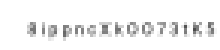


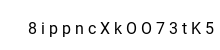


In [1]:
# In the experiments we are going to use PyTorchLightning (https://www.pytorchlightning.ai/)
!pip install pytorch_lightning torchinfo --quiet

     |████████████████████████████████| 526 kB 5.4 MB/s 
     |████████████████████████████████| 829 kB 44.4 MB/s 
     |████████████████████████████████| 132 kB 41.0 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
     |████████████████████████████████| 332 kB 42.1 MB/s 
     |████████████████████████████████| 1.1 MB 34.8 MB/s 
     |████████████████████████████████| 271 kB 47.3 MB/s 
     |████████████████████████████████| 160 kB 19.6 MB/s 
     |████████████████████████████████| 192 kB 45.7 MB/s 


In [4]:
import pytorch_lightning as pl
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO
from PIL import ImageFont, ImageDraw, Image
import numpy as np

from typing import List, Tuple, Union
import os
from tqdm.notebook import tqdm

import random
import string
from google.colab import drive
import zipfile

from torchinfo import summary
import torchvision
from torchvision.datasets import ImageFolder
import torch
from torch.utils.data import Dataset 
import torch.nn as nn
import torch.nn.functional as F


## Generate dataset

In this section, I generate a dataset with Clean image - Pixeled image couples. Our model should reconstruct the clean image Y from the corresponding pixeled image Y.  

In [14]:
# In the experiments I use only Roboto fonts to generate the dataset. 
# In order to obtain better model we should use more fonts.
req = requests.get("https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true")

In [17]:
def pixelate_rgb(img:np.array, window:int)->Image:
    n, m, _ = img.shape
    n, m = n - n % window, m - m % window
    img1 = np.zeros((n, m, 3))
    for x in range(0, n, window):
        for y in range(0, m, window):
            img1[x:x+window,y:y+window] = img[x:x+window,y:y+window].mean(axis=(0,1))
    return Image.fromarray((img1 * 1).astype(np.uint8))

def generate_text_image(out_file:str="out")-> Tuple[Image.Image, Image.Image]:
  len = random.randint(4, 20)
  text = ' '.join(random.choices(string.ascii_letters + string.digits + " ", k=len))
  fnt = ImageFont.truetype(BytesIO(req.content),16)
  h = random.randint(0, 20)
  w = random.randint(0, 200)
  b = Image.new('RGB',(256,64),color=(255, 255, 255))
  draw = ImageDraw.Draw(b)
  draw.text((w, h), text, fill=0, font=fnt)
  window = random.randint(2, 4)
  pixeled = pixelate_rgb(np.array(b), window=window)
  pixeled = pixeled.resize((256, 64), Image.DEFAULT_STRATEGY)
  #pixeled.save(f"{out_file}.png", format="png")
  return b, pixeled

In [19]:
def generate_dataset(k:int=100) -> None:

  if not os.path.isdir("dataset"):
    os.mkdir("dataset")

  if not os.path.isdir("dataset/clean"):
    os.mkdir("dataset/clean")
  
  if not os.path.isdir("dataset/pixeled"):
    os.mkdir("dataset/pixeled")

  for i in tqdm(range(k)):
    clean, pixeled = generate_text_image()
    pixeled.save(f"dataset/pixeled/{i}.png", format="png")
    clean.save(f"dataset/clean/{i}.png", format="png")


In [22]:
# generate dataset
# if you downloaded the dataset, you can skip this step and goto "Load the data" section
generate_dataset(20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

## Save the dataset

In [23]:
# save dataset
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [24]:
# zip dataset folder
def zipfolder(foldername:str, target_dir:str)->None:            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])


In [25]:
zipfolder("dataset", "dataset")

In [ ]:
os.mkdir("/content/gdrive/MyDrive/Depixelizer")

In [27]:
!cp dataset.zip /content/gdrive/MyDrive/Depixelizer/text_image_dataset.zip

## Get an example

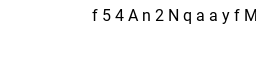

In [28]:
Image.open("/content/dataset/clean/15.png")

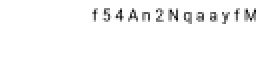

In [29]:
Image.open("/content/dataset/pixeled/15.png")

## Load the data

You can start from this section if you have already downloaded the dataset from the repository.

Copy the dataset in your drive, using the path: 
"/content/gdrive/MyDrive/Depixelizer/text_image_dataset.zip"

In [30]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
zipfile.ZipFile("/content/gdrive/MyDrive/Depixelizer/text_image_dataset.zip").extractall("dataset/")

In [31]:
data_dir = "dataset/"
img_height = 64
img_width = 256
batch_size = 32

In [32]:
def load_data()->Tuple[List[np.array], List[np.array]]:
  clean = list()
  pixeled = list()
  for f in tqdm(os.listdir("dataset/clean/")):
    clean_img = PIL.Image.open(f"dataset/clean/{f}")
    noisy = PIL.Image.open(f"dataset/pixeled/{f}")
    clean.append(np.array(clean_img))
    pixeled.append(np.array(noisy))
  
  return clean, pixeled

In [33]:
clean, pixeled = load_data()

  0%|          | 0/20000 [00:00<?, ?it/s]

In [34]:
print(np.array(clean).shape)
print(np.array(pixeled).shape)

(20000, 64, 256, 3)
(20000, 64, 256, 3)


## Torch Data Loading

Create an AutoEncoder Dataset and generate the train, val, test sets, and their DataLoaders.

In [35]:
class AutoencoderDataset(Dataset):
  def __init__(self, clean, pixeled, height, width):
    self.x = pixeled
    self.y = clean
    self.transform =torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),     
                                              torchvision.transforms.Resize((height, width)),
                                              torchvision.transforms.Normalize((0.5,),(0.5,)),
    ])


  def __len__(self):
    return len(self.x)
    
  
  def __getitem__(self, idx:int)->Tuple[torch.Tensor, torch.Tensor]:
    if torch.is_tensor(idx):
      idx = idx.tolist()
    x = self.x[idx]
    y = self.y[idx]
    
    x = self.transform(x)
    y = self.transform(y)
        
    return x, y


In [36]:
dataset = AutoencoderDataset(clean=clean, pixeled=pixeled, height=img_height, width=img_width)

In [37]:
dataset.__getitem__(0)[0].shape

torch.Size([3, 64, 256])

In [38]:
# split train val
train_set, val_set = torch.utils.data.random_split(dataset, [18000, 2000])
# split val test
val_set, test_set = torch.utils.data.random_split(val_set, [1200, 800])

In [39]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=64,
    shuffle=False
)

In [40]:
test_set.__getitem__(2)[0].shape

torch.Size([3, 64, 256])

## Model

Convolutional AutoEncoder Model:


```
=================================================================
Layer (type:depth-idx)                   Param #
=================================================================
AutoEncoder                              --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       168
│    └─BatchNorm2d: 2-2                  12
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       660
│    └─BatchNorm2d: 2-6                  24
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
│    └─Conv2d: 2-9                       2,616
│    └─BatchNorm2d: 2-10                 48
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
├─Sequential: 1-2                        --
│    └─ConvTranspose2d: 2-13             1,164
│    └─BatchNorm2d: 2-14                 24
│    └─ReLU: 2-15                        --
│    └─ConvTranspose2d: 2-16             294
│    └─BatchNorm2d: 2-17                 12
│    └─ReLU: 2-18                        --
│    └─ConvTranspose2d: 2-19             75
│    └─BatchNorm2d: 2-20                 6
├─MSELoss: 1-3                           --
=================================================================
Total params: 5,103
Trainable params: 5,103
Non-trainable params: 0
=================================================================

```


In [53]:
class AutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # encoder net
        self.encoder = nn.Sequential(
            # 256 x 64 x 3
            nn.Conv2d(3, 6, 3, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 128 x 32 x 6
            nn.Conv2d(6, 12, 3, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 64 x 16 x 12
            nn.Conv2d(12, 24, 3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # 32 x 8 x 24
        )

        # decoder net
        self.decoder = nn.Sequential(
            # 32 x 8 x 24
            nn.ConvTranspose2d(24, 12, 2, stride=2),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            # 64 x 16 x 12
            nn.ConvTranspose2d(12, 6, 2, stride=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            # 128 x 32 x 6
            nn.ConvTranspose2d(6, 3, 2, stride=2),
            nn.BatchNorm2d(3)
            # 256 x 64 x 3
        )
        
        # loss
        self.criterion = torch.nn.MSELoss()

    def forward(self, x):
        # encode
        x = self.encoder(x)
        # decode
        x = self.decoder(x)
        # sigmoid function
        x = F.sigmoid(x)        
        return x

    def get_bottleneck(self, x):
      return torch.flatten(self.encoder(x))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y, y_hat)
        self.log("train_loss",loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y, y_hat)
        self.log("test_loss", loss)
        return loss
      
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y, y_hat)
        self.log("val_loss",loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        y_hat = self(x)
        return y_hat

    def configure_optimizers(self):
        return torch.optim.Adam(model.parameters(), lr=0.001)

## Training

Train the model

In [54]:
# Callbacks
model_checkpoint = pl.callbacks.ModelCheckpoint(
    "/content/gdrive/MyDrive/Depixelizer/model/",
    filename="best",
    monitor = "val_loss",
    mode="min"
)

# early stopping
early_stopping = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min"
)

model = AutoEncoder()

In [ ]:
# create model output dir
if not os.path.isdir("/content/gdrive/MyDrive/Depixelizer/model/"):
  os.mkdir("/content/gdrive/MyDrive/Depixelizer/model/")


trainer = pl.Trainer(max_epochs=100, gpus=1, callbacks=[model_checkpoint, early_stopping])

# callbacks
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 3.5 K 
1 | decoder   | Sequential | 1.6 K 
2 | criterion | MSELoss    | 0     
-----------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/gdrive/MyDrive/Depixelizer/model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
summary(model)

In [ ]:
# save last version of the trained model
trainer.save_checkpoint("/content/gdrive/MyDrive/Depixelizer/model/last.ckpt")

## Predict (Testing)

In [ ]:
# compute the loss over the test set predictions
test_loss = trainer.test(model, dataloaders=test_loader)

In [ ]:
# get model predictions over the test set
predictions = trainer.predict(model, dataloaders=test_loader)

In [ ]:
# plot some predictions
n = 10
plt.figure(figsize=(80, 20))
for i in range(n):
    item = test_set.__getitem__(i)
    # display clean_img
    ax = plt.subplot(2, n, i + 1)
    plt.title("clean")
    plt.imshow(item[1].permute((1, 2, 0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(predictions[0][i].permute((1, 2, 0)))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Load model from checkpoint

In [ ]:
model = AutoEncoder()
model.load_from_checkpoint(checkpoint_path="/content/gdrive/MyDrive/Depixelizer/model/last.ckpt")
summary(model)

## Single example predict_fn (Serve mode)

In [ ]:
def predict_example(model:pl.LightningModule, e:np.array):
  transform =torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),     
                                              torchvision.transforms.Resize((img_height, img_width)),
                                              torchvision.transforms.Normalize((0.5,),(0.5,)),
    ])
  
  x = transform(e)
  # Tensor

  # Add batch dimension
  x = x.unsqueeze(0)
  # 1 x 3 x 64 x 256

  return model(x)[0]


In [ ]:
plt.imshow(torch.tensor(clean[0]))

In [ ]:
predicted_example = predict_example(e=clean[0], model=model)
plt.imshow(predicted_example.detach().permute((1, 2, 0)))